# Imports and parameters

In [1]:
import os
import astropy.units as u
import astropy.constants as const
import numpy as np
import copy
import matplotlib.pyplot as plt

from PerseusGammaCalibration import perseus_model_library
from PerseusGammaCalibration import perseus_data_library
import minot

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
outdir = os.getenv('CTAPHYS_OUT_DIR')+'Perseus_KSP_calibration'

# Define the models

In [3]:
cluster = perseus_model_library.default_model()
cluster.Npt_per_decade_integ = 50

In [4]:
Clist = []

#---------- eta = 1.5, alpha = 2.3
ctmp = copy.deepcopy(cluster)
radius = np.logspace(0,5,100000)*u.kpc
r,n = ctmp.get_density_gas_profile(radius)
ctmp.density_crp_model = {'name':'User', 'radius':radius, 'profile':n.value**1.5}
ctmp.spectrum_crp_model = {'name':'MomentumPowerLaw', 'Index':2.3, 'Mass':const.m_p*const.c**2}
ctmp.name = r'$\eta_{\rm CRp}=1.5$, $\alpha_{\rm CRp}=2.3$'
Clist.append(ctmp)

#---------- eta = 1, alpha = 2.3
ctmp = copy.deepcopy(cluster)
radius = np.logspace(0,5,100000)*u.kpc
r,n = ctmp.get_density_gas_profile(radius)
ctmp.density_crp_model = {'name':'User', 'radius':radius, 'profile':n.value**1.0}
ctmp.spectrum_crp_model = {'name':'MomentumPowerLaw', 'Index':2.3, 'Mass':const.m_p*const.c**2}
ctmp.name = r'$\eta_{\rm CRp}=1.0$, $\alpha_{\rm CRp}=2.3$'
Clist.append(ctmp)

#---------- eta = 0.5, alpha = 2.3
ctmp = copy.deepcopy(cluster)
radius = np.logspace(0,5,100000)*u.kpc
r,n = ctmp.get_density_gas_profile(radius)
ctmp.density_crp_model = {'name':'User', 'radius':radius, 'profile':n.value**0.5}
ctmp.spectrum_crp_model = {'name':'MomentumPowerLaw', 'Index':2.3, 'Mass':const.m_p*const.c**2}
ctmp.name = r'$\eta_{\rm CRp}=0.5$, $\alpha_{\rm CRp}=2.3$'
Clist.append(ctmp)

#---------- eta = 0.0, alpha = 2.3
ctmp = copy.deepcopy(cluster)
radius = np.logspace(0,5,100000)*u.kpc
r,n = ctmp.get_density_gas_profile(radius)
ctmp.density_crp_model = {'name':'User', 'radius':radius, 'profile':n.value**0.0}
ctmp.spectrum_crp_model = {'name':'MomentumPowerLaw', 'Index':2.3, 'Mass':const.m_p*const.c**2}
ctmp.name = r'$\eta_{\rm CRp}=0.0$, $\alpha_{\rm CRp}=2.3$'
Clist.append(ctmp)

#---------- eta = 1, alpha = 2.5
ctmp = copy.deepcopy(cluster)
ctmp.set_density_crp_isodens_scal_param(1.0)
ctmp.spectrum_crp_model = {'name':'MomentumPowerLaw', 'Index':2.5, 'Mass':const.m_p*const.c**2}
ctmp.name = r'$\eta_{\rm CRp}=1$, $\alpha_{\rm CRp}=2.5$'
Clist.append(ctmp)

#---------- eta = 1, alpha = 2.7
ctmp = copy.deepcopy(cluster)
ctmp.set_density_crp_isodens_scal_param(1.0)
ctmp.spectrum_crp_model = {'name':'MomentumPowerLaw', 'Index':2.7, 'Mass':const.m_p*const.c**2}
ctmp.name = r'$\eta_{\rm CRp}=1$, $\alpha_{\rm CRp}=2.7$'
Clist.append(ctmp)

# Energy ratio profile

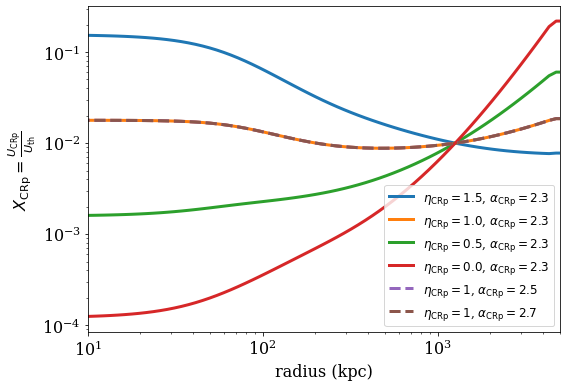

In [5]:
fig = plt.figure(0, figsize=(8, 6))
for i in [0,1,2,3]:
    r, x = Clist[i].get_crp_to_thermal_energy_profile()
    plt.loglog(r.to_value('kpc'), x, label=Clist[i].name, linewidth=3)
    
for i in [4,5]:
    r, x = Clist[i].get_crp_to_thermal_energy_profile()
    plt.loglog(r.to_value('kpc'), x, label=Clist[i].name, linestyle='--', linewidth=3)
    
plt.xlabel(r'radius (kpc)')
plt.ylabel(r'$X_{\rm CRp} = \frac{U_{\rm CRp}}{U_{\rm th}}$')
plt.xlim(10,5000)
plt.legend(fontsize=12, loc='lower right')
plt.savefig(outdir+'/CR_Xcrp_models.pdf')

# Gamma ray spectrum

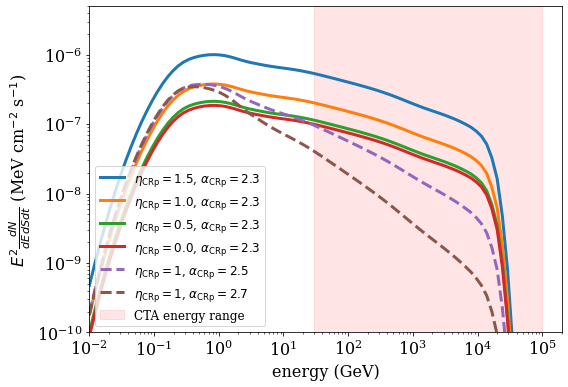

In [6]:
fig = plt.figure(0, figsize=(8, 6))
for i in [0,1,2,3]:
    e, s = Clist[i].get_gamma_spectrum(Rmax=Clist[i].R500, type_integral='cylindrical')
    plt.loglog(e.to_value('GeV'), (e*e*s).to_value('MeV s-1 cm-2'), label=Clist[i].name, linewidth=3)
    
for i in [4,5]:
    e, s = Clist[i].get_gamma_spectrum(Rmax=Clist[i].R500, type_integral='cylindrical')
    plt.loglog(e.to_value('GeV'), (e*e*s).to_value('MeV s-1 cm-2'), label=Clist[i].name, linestyle='--', linewidth=3)
    
plt.fill_between([30, 100e3], [0,0], [1e6,1e6], color='red', alpha=0.1, label='CTA energy range')
plt.xlabel(r'energy (GeV)')
plt.ylabel(r'$E^2\frac{dN}{dEdSdt}$ (MeV cm$^{-2}$ s$^{-1}$)')
plt.xlim(1e-2, 2e5)
plt.ylim(1e-10, 5e-6)
plt.legend(loc='lower left', fontsize=12)
plt.savefig(outdir+'/CR_Gamma_spectrum_models.pdf')

# Gamma ray profile

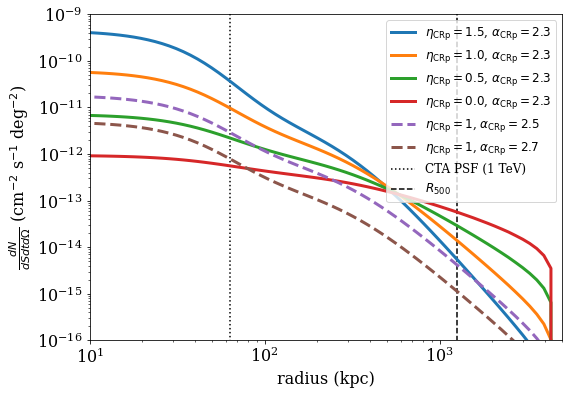

In [10]:
fig = plt.figure(0, figsize=(8, 6))
for i in [0,1,2,3]:
    r, p = Clist[i].get_gamma_profile(Emin=150*u.GeV, Emax=50*u.TeV)
    plt.loglog(r.to_value('kpc'), p.to_value('s-1 cm-2 deg-2'), label=Clist[i].name, linewidth=3)
    
for i in [4,5]:
    r, p = Clist[i].get_gamma_profile(Emin=150*u.GeV, Emax=50*u.TeV)
    plt.loglog(r.to_value('kpc'), p.to_value('s-1 cm-2 deg-2'), label=Clist[i].name, linestyle='--', linewidth=3)
plt.vlines((0.05*u.deg*cluster.cosmo.kpc_proper_per_arcmin(cluster.redshift)).to_value('kpc'), 0,1, linestyle=':', color='k', label='CTA PSF (1 TeV)')
plt.vlines(cluster.R500.to_value('kpc'), 0,1, linestyle='--', color='k', label='$R_{500}$')
plt.xlabel(r'radius (kpc)')
plt.ylabel(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ deg$^{-2}$)')
plt.xlim(10,5e3)
plt.ylim(1e-16,1e-9)
plt.legend(fontsize=12)
plt.savefig(outdir+'/CR_Gamma_profile_models.pdf')

# Gamma ray enclosed flux

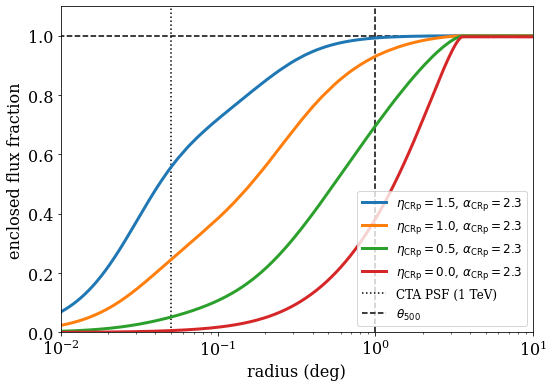

In [8]:
theta = np.logspace(-2, 2, 1000)*u.deg 
radius = theta.to_value('rad')* cluster.D_ang.to('kpc')

fig = plt.figure(0, figsize=(8, 6))
for i in [0,1,2,3]:
    Clist[i].Npt_per_decade_integ = 100
    Ftot = Clist[i].get_gamma_flux(Emin=150*u.GeV, Emax=50*u.TeV, Rmax=Clist[i].R_truncation, type_integral='cylindrical')
    fr = Clist[i].get_gamma_flux(Emin=150*u.GeV, Emax=50*u.TeV, Rmax=radius, type_integral='cylindrical')
    plt.plot(theta.to_value('deg'), (fr/Ftot).to_value(''), label=Clist[i].name, linewidth=3)
    
plt.xscale('log')
plt.vlines(0.05, 0,10, linestyle=':', color='k', label='CTA PSF (1 TeV)')
plt.vlines(cluster.theta500.to_value('deg'), 0,10, linestyle='--', color='k', label='$\\theta_{500}$')
plt.hlines(1, 0,100, linestyle='--', color='k')
plt.xlabel(r'radius (deg)')
plt.ylabel(r'enclosed flux fraction')
plt.xlim(0.01, 10)
plt.ylim(0, 1.1)
plt.legend(fontsize=12)
plt.savefig(outdir+'/CR_Gamma_flux_fraction.pdf')

In [11]:
cluster = perseus_model_library.default_model()
print('Baseline model')
print('     hadronic', 1e14*cluster.get_gamma_flux(Rmax=cluster.R500, type_integral='cylindrical', Emin=150*u.GeV))
print('     IC      ', 1e14*cluster.get_ic_flux(Rmax=cluster.R500, type_integral='cylindrical', Emin=150*u.GeV))

cluster = perseus_model_library.set_pure_hadronic_model(cluster, ('density', 1.5), 20e-2, 2.0)
print('Most favorable model')
print('     hadronic', 1e14*cluster.get_gamma_flux(Rmax=cluster.R500, type_integral='cylindrical', Emin=150*u.GeV))
print('     IC      ', 1e14*cluster.get_ic_flux(Rmax=cluster.R500, type_integral='cylindrical', Emin=150*u.GeV))

Baseline model
     hadronic 70.19263888584408 1 / (cm2 s)
     IC       2.0928325322191363 1 / (cm2 s)
Most favorable model
     hadronic 11373.788642844542 1 / (cm2 s)
     IC       625.3594660198069 1 / (cm2 s)


# Compare inverse Compton and hadronic

In [10]:
cluster = perseus_model_library.default_model()
cluster = perseus_model_library.set_pure_hadronic_model(cluster, ('density', 0.75), 0.075, 2.5)
cluster.Npt_per_decade_integ = 50

In [11]:
radio_data = perseus_data_library.get_radio_data(cluster.cosmo, cluster.redshift, prof_file='Pedlar1990', check=False)

1.029022681940856
---> Check spectrum/profile consistency for Pedlar 1990 data, but no correction.


In [12]:
Clist = []
C1 = perseus_model_library.set_magnetic_field_model(cluster, case='Taylor2006')
Clist.append(C1)
C2 = perseus_model_library.set_magnetic_field_model(cluster, case='Walker2017')
Clist.append(C2)
C3 = perseus_model_library.set_magnetic_field_model(cluster, case='Bonafede2010best')
Clist.append(C3)
C4 = perseus_model_library.set_magnetic_field_model(cluster, case='Bonafede2010low')
Clist.append(C4)
C5 = perseus_model_library.set_magnetic_field_model(cluster, case='Bonafede2010up')
Clist.append(C5)
C6 = perseus_model_library.set_magnetic_field_model(cluster, case='Bonafede2010std')
Clist.append(C6)

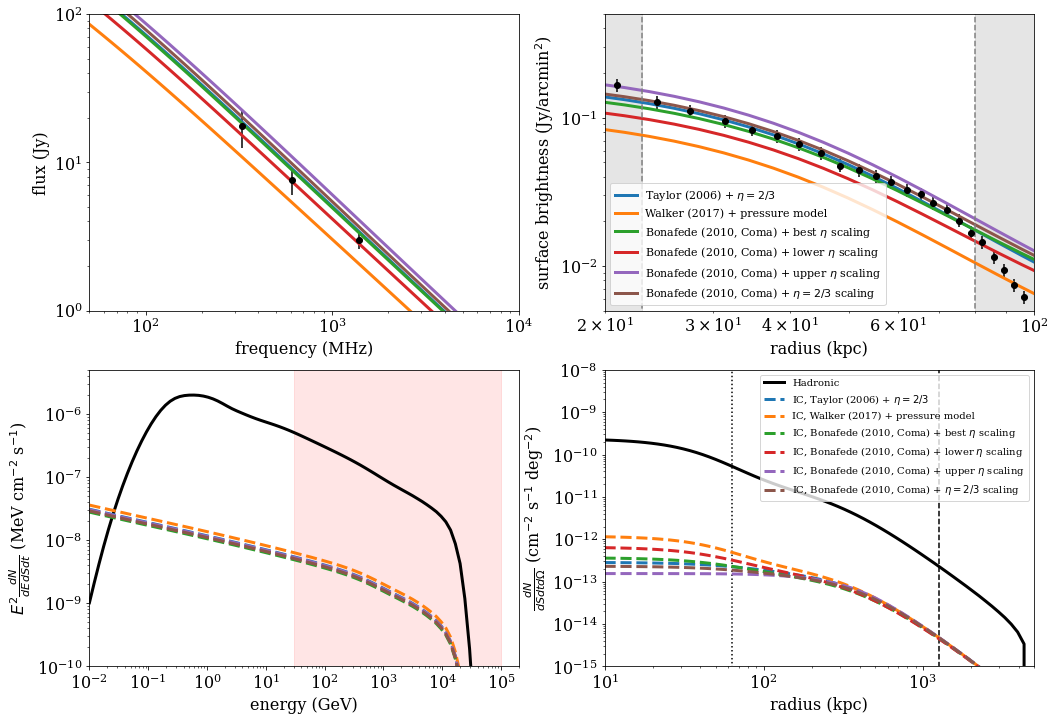

In [13]:
plt.figure(0, figsize=(16,12))

ax = plt.subplot(221)
plt.errorbar(radio_data['spectrum']['freq'].to_value('MHz'), radio_data['spectrum']['flux'].to_value('Jy'), radio_data['spectrum']['error'].to_value('Jy'),
            marker='o', linestyle='', color='k')#, label='Data')
for c in Clist:
    f, s = c.get_synchrotron_spectrum(Rmin=radio_data['info']['spec_Rmin'], Rmax=radio_data['info']['spec_Rmax'], 
                                             type_integral='cylindrical')
    plt.loglog(f.to_value('MHz'), s.to_value('Jy'), label=c.name, linewidth=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency (MHz)')
plt.ylabel('flux (Jy)')
plt.xlim(50,10000)
plt.ylim(1,100)

ax = plt.subplot(222)
plt.errorbar(radio_data['profile']['radius'].to_value('kpc'), radio_data['profile']['flux'].to_value('Jy arcmin-2'), 
             radio_data['profile']['error'].to_value('Jy arcmin-2'),marker='o', linestyle='', color='k')
for c in Clist:
    r, p = c.get_synchrotron_profile(freq0=radio_data['info']['prof_freq'])
    plt.loglog(r.to_value('kpc'), p.to_value('Jy arcmin-2'), label=c.name, linewidth=3)

plt.plot([radio_data['info']['prof_Rmin'].to_value('kpc'),radio_data['info']['prof_Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.plot([radio_data['info']['prof_Rmax'].to_value('kpc'),radio_data['info']['prof_Rmax'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,radio_data['info']['prof_Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.2)
plt.fill_between([radio_data['info']['prof_Rmax'].to_value('kpc'), radio_data['info']['prof_Rmax'].to_value('kpc')*1e3], [0,0], [1e6,1e6], color='grey', alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('radius (kpc)')
plt.ylabel('surface brightness (Jy/arcmin$^2$)')
plt.xlim(20,100)
plt.ylim(5e-3,5e-1)
plt.legend(fontsize=11)

ax = plt.subplot(223)
e, s = Clist[0].get_gamma_spectrum(Rmax=Clist[0].R500, type_integral='cylindrical')
plt.loglog(e.to_value('GeV'), (e*e*s).to_value('MeV s-1 cm-2'), label='Hadronic', linewidth=3, linestyle='-', color='k')
for c in Clist:
    e, s = c.get_ic_spectrum(Rmax=c.R500, type_integral='cylindrical')
    plt.loglog(e.to_value('GeV'), (e*e*s).to_value('MeV s-1 cm-2'), label='IC, '+c.name, linewidth=3, linestyle='--')
plt.fill_between([30, 100e3], [0,0], [1e6,1e6], color='red', alpha=0.1, label='CTA energy range')
plt.xlabel(r'energy (GeV)')
plt.ylabel(r'$E^2\frac{dN}{dEdSdt}$ (MeV cm$^{-2}$ s$^{-1}$)')
plt.xlim(1e-2, 2e5)
plt.ylim(1e-10, 5e-6)
#plt.legend(loc='lower left', fontsize=12)

ax = plt.subplot(224)
r, p = Clist[0].get_gamma_profile(Emin=50*u.GeV, Emax=100*u.TeV)
plt.loglog(r.to_value('kpc'), p.to_value('s-1 cm-2 deg-2'), label='Hadronic', linewidth=3, linestyle='-', color='k')
for c in Clist:
    r, p = c.get_ic_profile(Emin=50*u.GeV, Emax=100*u.TeV)
    plt.loglog(r.to_value('kpc'), p.to_value('s-1 cm-2 deg-2'), label='IC, '+c.name, linewidth=3, linestyle='--')
plt.vlines((0.05*u.deg*cluster.cosmo.kpc_proper_per_arcmin(cluster.redshift)).to_value('kpc'), 0,1, linestyle=':', color='k')#, label='CTA PSF (1 TeV)')
plt.vlines(cluster.R500.to_value('kpc'), 0,1, linestyle='--', color='k')#, label='$R_{500}$')
plt.xlabel(r'radius (kpc)')
plt.ylabel(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ deg$^{-2}$)')
plt.xlim(10,5e3)
plt.ylim(1e-15,1e-8)
plt.legend(fontsize=10)

plt.savefig(outdir+'/CR_IC_vs_hadronic_models_PH.pdf')

In [14]:
cluster = perseus_model_library.default_model()
cluster = perseus_model_library.set_pure_leptonic_model(cluster, ('density', 2.0), 1.5e-4, 2.5)
cluster.cre1_loss_model = 'Steady'
cluster.Npt_per_decade_integ = 50

In [15]:
Clist = []
C1 = perseus_model_library.set_magnetic_field_model(cluster, case='Taylor2006')
Clist.append(C1)
C2 = perseus_model_library.set_magnetic_field_model(cluster, case='Walker2017')
Clist.append(C2)
C3 = perseus_model_library.set_magnetic_field_model(cluster, case='Bonafede2010best')
Clist.append(C3)
C4 = perseus_model_library.set_magnetic_field_model(cluster, case='Bonafede2010low')
Clist.append(C4)
C5 = perseus_model_library.set_magnetic_field_model(cluster, case='Bonafede2010up')
Clist.append(C5)
C6 = perseus_model_library.set_magnetic_field_model(cluster, case='Bonafede2010std')
Clist.append(C6)

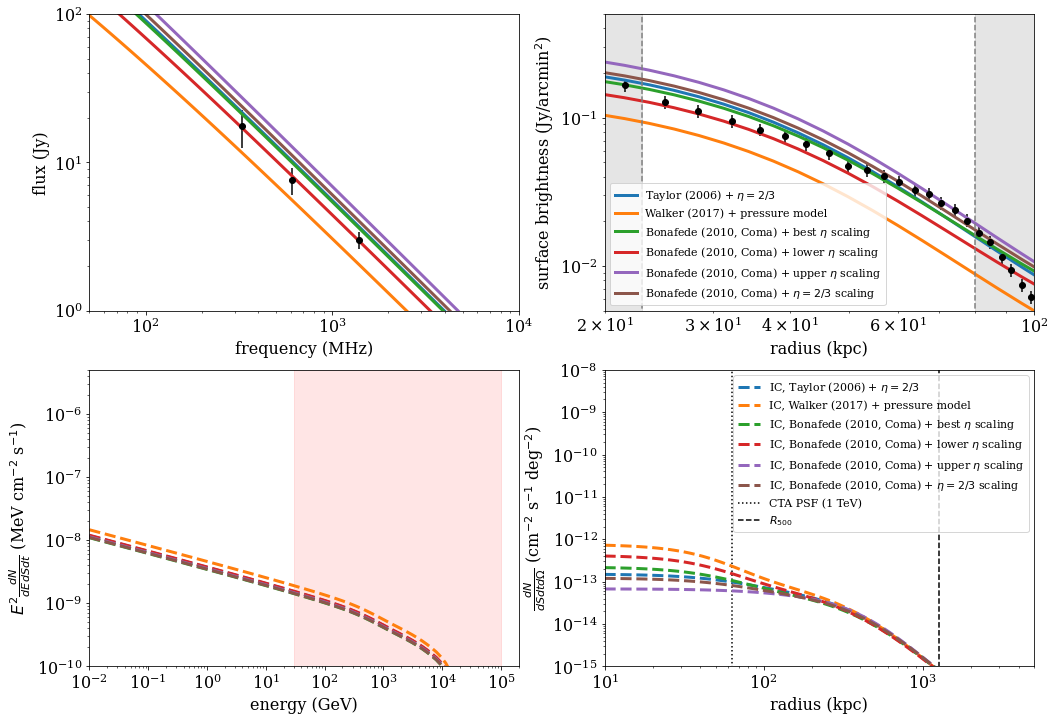

In [16]:
plt.figure(0, figsize=(16,12))

ax = plt.subplot(221)
plt.errorbar(radio_data['spectrum']['freq'].to_value('MHz'), radio_data['spectrum']['flux'].to_value('Jy'), radio_data['spectrum']['error'].to_value('Jy'),
            marker='o', linestyle='', color='k')#, label='Data')
for c in Clist:
    f, s = c.get_synchrotron_spectrum(Rmin=radio_data['info']['spec_Rmin'], Rmax=radio_data['info']['spec_Rmax'], 
                                             type_integral='cylindrical')
    plt.loglog(f.to_value('MHz'), s.to_value('Jy'), label=c.name, linewidth=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency (MHz)')
plt.ylabel('flux (Jy)')
plt.xlim(50,10000)
plt.ylim(1,100)

ax = plt.subplot(222)
plt.errorbar(radio_data['profile']['radius'].to_value('kpc')*1.03, radio_data['profile']['flux'].to_value('Jy arcmin-2'), 
             radio_data['profile']['error'].to_value('Jy arcmin-2'),marker='o', linestyle='', color='k')
for c in Clist:
    r, p = c.get_synchrotron_profile(freq0=radio_data['info']['prof_freq'])
    plt.loglog(r.to_value('kpc'), p.to_value('Jy arcmin-2'), label=c.name, linewidth=3)

plt.plot([radio_data['info']['prof_Rmin'].to_value('kpc'),radio_data['info']['prof_Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.plot([radio_data['info']['prof_Rmax'].to_value('kpc'),radio_data['info']['prof_Rmax'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,radio_data['info']['prof_Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.2)
plt.fill_between([radio_data['info']['prof_Rmax'].to_value('kpc'), radio_data['info']['prof_Rmax'].to_value('kpc')*1e3], [0,0], [1e6,1e6], color='grey', alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('radius (kpc)')
plt.ylabel('surface brightness (Jy/arcmin$^2$)')
plt.xlim(20,100)
plt.ylim(5e-3,5e-1)
plt.legend(fontsize=11)

ax = plt.subplot(223)
for c in Clist:
    e, s = c.get_ic_spectrum(Rmax=c.R500, type_integral='cylindrical')
    plt.loglog(e.to_value('GeV'), (e*e*s).to_value('MeV s-1 cm-2'), label='IC, '+c.name, linewidth=3, linestyle='--')
plt.fill_between([30, 100e3], [0,0], [1e6,1e6], color='red', alpha=0.1, label='CTA energy range')
plt.xlabel(r'energy (GeV)')
plt.ylabel(r'$E^2\frac{dN}{dEdSdt}$ (MeV cm$^{-2}$ s$^{-1}$)')
plt.xlim(1e-2, 2e5)
plt.ylim(1e-10, 5e-6)
#plt.legend(loc='lower left', fontsize=12)

ax = plt.subplot(224)
for c in Clist:
    r, p = c.get_ic_profile(Emin=50*u.GeV, Emax=100*u.TeV)
    plt.loglog(r.to_value('kpc'), p.to_value('s-1 cm-2 deg-2'), label='IC, '+c.name, linewidth=3, linestyle='--')
plt.vlines((0.05*u.deg*cluster.cosmo.kpc_proper_per_arcmin(cluster.redshift)).to_value('kpc'), 0,1, linestyle=':', color='k', label='CTA PSF (1 TeV)')
plt.vlines(cluster.R500.to_value('kpc'), 0,1, linestyle='--', color='k', label='$R_{500}$')
plt.xlabel(r'radius (kpc)')
plt.ylabel(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ deg$^{-2}$)')
plt.xlim(10,5e3)
plt.ylim(1e-15,1e-8)
plt.legend(fontsize=11)

plt.savefig(outdir+'/CR_IC_vs_hadronic_models_PL.pdf')

# Cutoff in spectrum with pure leptonic

In [17]:
cluster = perseus_model_library.default_model()
cluster = perseus_model_library.set_pure_leptonic_model(cluster, ('density', 0.75), 8e-1, 3.5)
cluster.cre1_loss_model = 'None'
cluster.Npt_per_decade_integ = 50

In [18]:
radio_data = perseus_data_library.get_radio_data(cluster.cosmo, cluster.redshift, prof_file='Pedlar1990', check=False)

1.029022681940856
---> Check spectrum/profile consistency for Pedlar 1990 data, but no correction.


In [19]:
Clist = []

ctmp = copy.deepcopy(cluster)
ctmp.spectrum_cre1_model = {'name':'ExponentialCutoffPowerLaw', 'Index':3.5, 'CutoffEnergy':1e1*u.GeV}
ctmp.name = r'$10^{1}$ GeV'
Clist.append(ctmp)

ctmp = copy.deepcopy(cluster)
ctmp.spectrum_cre1_model = {'name':'ExponentialCutoffPowerLaw', 'Index':3.5, 'CutoffEnergy':1e2*u.GeV}
ctmp.name = r'$10^{2}$ GeV'
Clist.append(ctmp)

ctmp = copy.deepcopy(cluster)
ctmp.spectrum_cre1_model = {'name':'ExponentialCutoffPowerLaw', 'Index':3.5, 'CutoffEnergy':1e3*u.GeV}
ctmp.name = r'$10^{3}$ GeV'
Clist.append(ctmp)

ctmp = copy.deepcopy(cluster)
ctmp.spectrum_cre1_model = {'name':'ExponentialCutoffPowerLaw', 'Index':3.5, 'CutoffEnergy':1e4*u.GeV}
ctmp.name = r'$10^{4}$ GeV'
Clist.append(ctmp)

ctmp = copy.deepcopy(cluster)
ctmp.spectrum_cre1_model = {'name':'ExponentialCutoffPowerLaw', 'Index':3.5, 'CutoffEnergy':1e5*u.GeV}
ctmp.name = r'$10^{5}$ GeV'
Clist.append(ctmp)

ctmp = copy.deepcopy(cluster)
ctmp.spectrum_cre1_model = {'name':'ExponentialCutoffPowerLaw', 'Index':3.5, 'CutoffEnergy':1e6*u.GeV}
ctmp.name = r'$10^{6}$ GeV'
Clist.append(ctmp)

ctmp = copy.deepcopy(cluster)
ctmp.spectrum_cre1_model = {'name':'ExponentialCutoffPowerLaw', 'Index':3.5, 'CutoffEnergy':1e7*u.GeV}
ctmp.name = r'$10^{7}$ GeV'
Clist.append(ctmp)

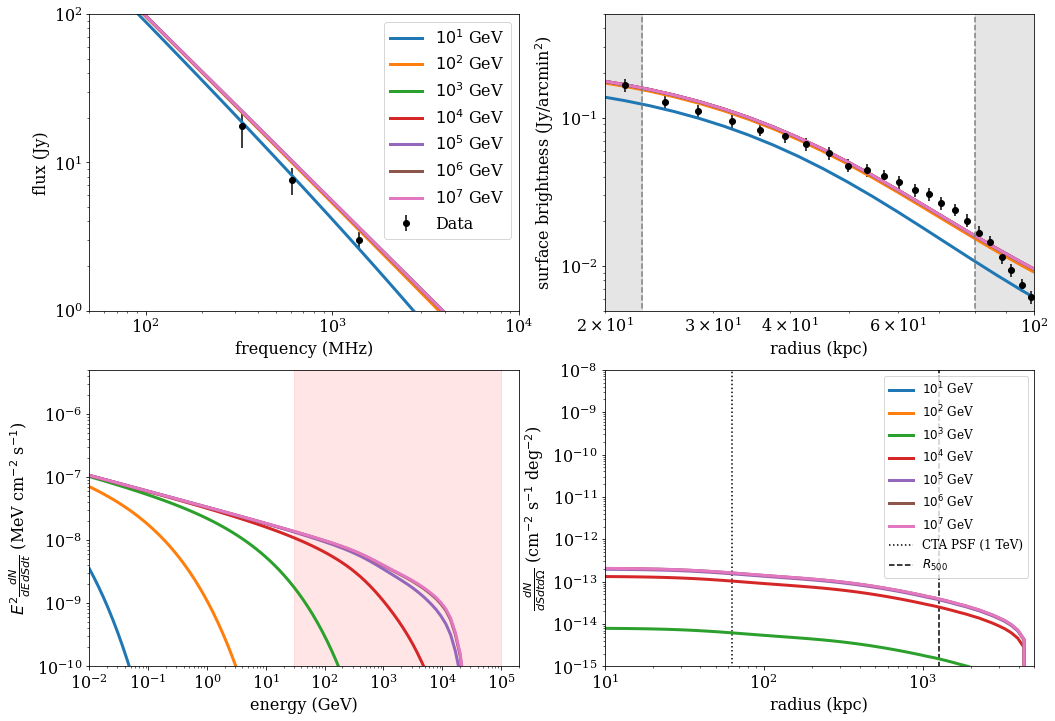

In [20]:
plt.figure(0, figsize=(16,12))

ax = plt.subplot(221)
plt.errorbar(radio_data['spectrum']['freq'].to_value('MHz'), radio_data['spectrum']['flux'].to_value('Jy'), radio_data['spectrum']['error'].to_value('Jy'),
            marker='o', linestyle='', color='k', label='Data')
for c in Clist:
    f, s = c.get_synchrotron_spectrum(Rmin=radio_data['info']['spec_Rmin'], Rmax=radio_data['info']['spec_Rmax'], 
                                             type_integral='cylindrical')
    plt.loglog(f.to_value('MHz'), s.to_value('Jy'), label=c.name, linewidth=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency (MHz)')
plt.ylabel('flux (Jy)')
plt.xlim(50,10000)
plt.ylim(1,100)
plt.legend()

ax = plt.subplot(222)
plt.errorbar(radio_data['profile']['radius'].to_value('kpc')*1.03, radio_data['profile']['flux'].to_value('Jy arcmin-2'), 
             radio_data['profile']['error'].to_value('Jy arcmin-2'),marker='o', linestyle='', color='k')
for c in Clist:
    r, p = c.get_synchrotron_profile(freq0=radio_data['info']['prof_freq'])
    plt.loglog(r.to_value('kpc'), p.to_value('Jy arcmin-2'), label=c.name, linewidth=3)

plt.plot([radio_data['info']['prof_Rmin'].to_value('kpc'),radio_data['info']['prof_Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.plot([radio_data['info']['prof_Rmax'].to_value('kpc'),radio_data['info']['prof_Rmax'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,radio_data['info']['prof_Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.2)
plt.fill_between([radio_data['info']['prof_Rmax'].to_value('kpc'), radio_data['info']['prof_Rmax'].to_value('kpc')*1e3], [0,0], [1e6,1e6], color='grey', alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('radius (kpc)')
plt.ylabel('surface brightness (Jy/arcmin$^2$)')
plt.xlim(20,100)
plt.ylim(5e-3,5e-1)

ax = plt.subplot(223)
for c in Clist:
    e, s = c.get_ic_spectrum(Rmax=c.R500, type_integral='cylindrical')
    plt.loglog(e.to_value('GeV'), (e*e*s).to_value('MeV s-1 cm-2'), label=c.name, linewidth=3)
plt.fill_between([30, 100e3], [0,0], [1e6,1e6], color='red', alpha=0.1, label='CTA energy range')
plt.xlabel(r'energy (GeV)')
plt.ylabel(r'$E^2\frac{dN}{dEdSdt}$ (MeV cm$^{-2}$ s$^{-1}$)')
plt.xlim(1e-2, 2e5)
plt.ylim(1e-10, 5e-6)
#plt.legend(loc='lower left', fontsize=12)

ax = plt.subplot(224)
for c in Clist:
    r, p = c.get_ic_profile(Emin=50*u.GeV, Emax=100*u.TeV)
    plt.loglog(r.to_value('kpc'), p.to_value('s-1 cm-2 deg-2'), label=c.name, linewidth=3)
plt.vlines((0.05*u.deg*cluster.cosmo.kpc_proper_per_arcmin(cluster.redshift)).to_value('kpc'), 0,1, linestyle=':', color='k', label='CTA PSF (1 TeV)')
plt.vlines(cluster.R500.to_value('kpc'), 0,1, linestyle='--', color='k', label='$R_{500}$')
plt.xlabel(r'radius (kpc)')
plt.ylabel(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ deg$^{-2}$)')
plt.xlim(10,5e3)
plt.ylim(1e-15,1e-8)
plt.legend(fontsize=12)

plt.savefig(outdir+'/CR_IC_vs_hadronic_models_cutoff.pdf')